In [1]:
import SimpleITK as sitk
from pathlib import Path
import itertools
import json
import numpy as np
from tqdm import tqdm
from notebooks.utils import init_stats, store_stats, print_stats

# Compute Slicer baseline

Here we morph prostates and targets using the Prostate MRI-US Contour Propagation algorithm and we collect the Dice coefficient between warped
MRI and US, for both prostates and targets. We also compute some shape errors on the targets, like centroid distance, volume and roundness difference.

In [7]:
base_path = Path(r"R:\DATASET_PROSTATE")
path_reg = base_path / "reg"
path_mr = base_path / "mri"
path_us = base_path / "us"

dice_filter = sitk.LabelOverlapMeasuresImageFilter()
shape_filter = sitk.LabelShapeStatisticsImageFilter()
shape_filter.ComputePerimeterOff()
shape_filter.ComputeFeretDiameterOff()
shape_filter.ComputeOrientedBoundingBoxOff()

def load_and_stats(mr_seg_path, us_seg_path, transform_pre, transform_def, shape_stats=False, eval_deformation=True, eval_initial=True):
    # load
    mr_seg = sitk.ReadImage(str(mr_seg_path), imageIO="NrrdImageIO")
    us_seg = sitk.ReadImage(str(us_seg_path), imageIO="NrrdImageIO")
    # deform MR
    transform = sitk.CompositeTransform(transform_pre)
    transform.AddTransform(transform_def)
    mr_seg_def = sitk.Resample(mr_seg, us_seg, transform, sitk.sitkNearestNeighbor)

    stats = {}

    ###
    #  Get stats of MR_def and US
    ###

    # calculate Dice between MR and US
    dice_filter.Execute(us_seg, mr_seg_def)
    stats["dice"] = dice_filter.GetDiceCoefficient()

    if shape_stats:
        # calculate other stats
        shape_filter.Execute(mr_seg_def)
        # get MR stats
        if shape_filter.GetNumberOfLabels() > 0:
            mr_def_centroid = np.array(shape_filter.GetCentroid(1))
            mr_def_elongation = shape_filter.GetElongation(1)
            mr_def_roundness = shape_filter.GetRoundness(1)
            mr_def_flatness = shape_filter.GetFlatness(1)
            mr_def_size = shape_filter.GetPhysicalSize(1)
        else:
            print("MR segmentation annihilated after deformation, no results here...")
            mr_def_centroid = np.array([np.inf, np.inf, np.inf])
            mr_def_elongation = 0
            mr_def_roundness = 0
            mr_def_flatness = 0
            mr_def_size = np.inf

        # get US stats
        shape_filter.Execute(us_seg)
        us_centroid = np.array(shape_filter.GetCentroid(1))
        us_elongation = shape_filter.GetElongation(1)
        us_roundness = shape_filter.GetRoundness(1)
        us_flatness = shape_filter.GetFlatness(1)
        us_size = shape_filter.GetPhysicalSize(1)

        # get the errors
        stats["error_centroid"] = np.linalg.norm(mr_def_centroid - us_centroid)
        stats["error_elongation"] = np.linalg.norm(mr_def_elongation - us_elongation)
        stats["error_roundness"] = np.linalg.norm(mr_def_roundness - us_roundness)
        stats["error_flatness"] = np.linalg.norm(mr_def_flatness - us_flatness)
        stats["error_size"] = np.linalg.norm(mr_def_size - us_size)

    ###
    #  Get stats of MR pre- and post-deformation
    ###
    if eval_initial or eval_deformation:
        # images must be in same space for the Dice filter!
        mr_seg = sitk.Resample(mr_seg, us_seg, transform_pre, sitk.sitkNearestNeighbor)
        # get MR stats
        shape_filter.Execute(mr_seg)
        mr_centroid = np.array(shape_filter.GetCentroid(1))
        mr_elongation = shape_filter.GetElongation(1)
        mr_roundness = shape_filter.GetRoundness(1)
        mr_flatness = shape_filter.GetFlatness(1)
        mr_size = shape_filter.GetPhysicalSize(1)

    if eval_deformation:
        # calculate Dice between MR and MR_def
        dice_filter.Execute(mr_seg, mr_seg_def)
        stats["dice_def"] = dice_filter.GetDiceCoefficient()

        if shape_stats:
            # get the errors
            stats["error_centroid_def"] = np.linalg.norm(mr_def_centroid - mr_centroid)
            stats["error_elongation_def"] = np.linalg.norm(mr_def_elongation - mr_elongation)
            stats["error_roundness_def"] = np.linalg.norm(mr_def_roundness - mr_roundness)
            stats["error_flatness_def"] = np.linalg.norm(mr_def_flatness - mr_flatness)
            stats["error_size_def"] = np.linalg.norm(mr_def_size - mr_size)

    if eval_initial:
        # calculate Dice between MR and US
        dice_filter.Execute(mr_seg, us_seg)
        stats["dice_pre"] = dice_filter.GetDiceCoefficient()

        if shape_stats:
            # get the errors
            stats["error_centroid_pre"] = np.linalg.norm(mr_centroid - us_centroid)
            stats["error_elongation_pre"] = np.linalg.norm(mr_elongation - us_elongation)
            stats["error_roundness_pre"] = np.linalg.norm(mr_roundness - us_roundness)
            stats["error_flatness_pre"] = np.linalg.norm(mr_flatness - us_flatness)
            stats["error_size_pre"] = np.linalg.norm(mr_size - us_size)

    return stats

def create_baseline_data(path_reg_patient, path_mr_data, path_us_data):

    results = {}

    # find the files
    path_pre = path_reg_patient / f"pre_{path_mr_data.name}_{path_us_data.name}.h5"
    path_def = path_reg_patient / f"def_{path_mr_data.name}_{path_us_data.name}.h5"
    # load the transforms
    trans_pre = sitk.ReadTransform(str(path_pre))
    trans_def = sitk.ReadTransform(str(path_def))

    #######
    # Dice of prostate
    paths_prostate_mr = list(path_mr_data.rglob("Prostate*"))[0]
    paths_prostate_us = list(path_us_data.rglob("Prostate*"))[0]
    stats = load_and_stats(paths_prostate_mr, paths_prostate_us, trans_pre, trans_def, shape_stats=False)
    results[f"prostate"] = stats
    # print(f"\t\tdone prostate: {stats['dice']*100:.2f}%")

    #######
    # Dice of targets
    paths_targets_mr = sorted(path_mr_data.rglob("Target*"))
    paths_targets_us = sorted(path_us_data.rglob("Target*"))
    length = min(len(paths_targets_mr), len(paths_targets_us))
    # for each pair of targets (here we consider targets with same names, since they are the same actual target)
    for path_target_mr, path_target_us in zip(paths_targets_mr[:length], paths_targets_us[:length]):
        # make names
        mr_target_name, us_target_name = path_target_mr.stem.split('_')[0], path_target_us.stem.split('_')[0]
        # find stats
        stats = load_and_stats(path_target_mr, path_target_us, trans_pre, trans_def, shape_stats=True)
        results[f"{mr_target_name}_{us_target_name}"] = stats
        # log some stats
        # print(f"\t\tdone {mr_target_name} vs {us_target_name}: {stats['dice']*100:.2f}%  --  {stats['error_centroid']:.2f} mm")

    return results

Compute all of the cases

In [ ]:
def batch_create_baseline(path_reg, path_mr, path_us):
    # create data for each patient registration
    for reg_patient in tqdm(path_reg.iterdir()):
        print(f"{reg_patient.name}")
        mr_patient, us_patient = path_mr / reg_patient.name, path_us / reg_patient.name
        mr_data_names, us_data_names = [f.name for f in mr_patient.iterdir()], [f.name for f in us_patient.iterdir()]

        for mr_data_name, us_data_name in itertools.product(mr_data_names, us_data_names):
            # prepare patient folders
            mr_data, us_data = mr_patient / mr_data_name, us_patient / us_data_name
            print(f"\t{mr_data.name} | {us_data.name}")

            results = create_baseline_data(reg_patient, mr_data, us_data)

            # save everything
            with open(str(reg_patient / f"results_{mr_data_name}_{us_data_name}.json"), "w") as f:
                json.dump(results, f)

batch_create_baseline(path_reg, path_mr, path_us)

Compute a specific subset of cases

In [ ]:
base_path = Path(r"R:\DATASET_PROSTATE")
path_reg = base_path / "reg"
path_mr = base_path / "mri"
path_us = base_path / "us"

dice_filter = sitk.LabelOverlapMeasuresImageFilter()
shape_filter = sitk.LabelShapeStatisticsImageFilter()
shape_filter.ComputePerimeterOff()
shape_filter.ComputeFeretDiameterOff()
shape_filter.ComputeOrientedBoundingBoxOff()

def tmp_load(mr_seg_path, us_seg_path, transform_pre):
    # load
    mr_seg = sitk.ReadImage(str(mr_seg_path), imageIO="NrrdImageIO")
    us_seg = sitk.ReadImage(str(us_seg_path), imageIO="NrrdImageIO")
    # images must be in same space for the Dice filter!
    mr_seg = sitk.Resample(mr_seg, us_seg, transform_pre, sitk.sitkNearestNeighbor)

    stats = {}

    # get US stats
    shape_filter.Execute(us_seg)
    us_centroid = np.array(shape_filter.GetCentroid(1))
    us_elongation = shape_filter.GetElongation(1)
    us_roundness = shape_filter.GetRoundness(1)
    us_flatness = shape_filter.GetFlatness(1)
    us_size = shape_filter.GetPhysicalSize(1)

    # get MR stats
    shape_filter.Execute(mr_seg)
    mr_centroid = np.array(shape_filter.GetCentroid(1))
    mr_elongation = shape_filter.GetElongation(1)
    mr_roundness = shape_filter.GetRoundness(1)
    mr_flatness = shape_filter.GetFlatness(1)
    mr_size = shape_filter.GetPhysicalSize(1)

    # calculate Dice between MR and US
    dice_filter.Execute(mr_seg, us_seg)
    stats["dice_pre"] = dice_filter.GetDiceCoefficient()

    # get the errors
    stats["error_centroid_pre"] = np.linalg.norm(mr_centroid - us_centroid)
    stats["error_elongation_pre"] = np.linalg.norm(mr_elongation - us_elongation)
    stats["error_roundness_pre"] = np.linalg.norm(mr_roundness - us_roundness)
    stats["error_flatness_pre"] = np.linalg.norm(mr_flatness - us_flatness)
    stats["error_size_pre"] = np.linalg.norm(mr_size - us_size)

    return stats

def tmp(path_reg_patient, path_mr_data, path_us_data):

    results = {}

    # find the files
    path_pre = path_reg_patient / f"pre_{path_mr_data.name}_{path_us_data.name}.h5"
    # load the transforms
    trans_pre = sitk.ReadTransform(str(path_pre))

    #######
    # Dice of prostate
    paths_prostate_mr = list(path_mr_data.rglob("Prostate*"))[0]
    paths_prostate_us = list(path_us_data.rglob("Prostate*"))[0]
    results[f"prostate"] = tmp_load(paths_prostate_mr, paths_prostate_us, trans_pre)

    #######
    # Dice of targets
    paths_targets_mr = sorted(path_mr_data.rglob("Target*"))
    paths_targets_us = sorted(path_us_data.rglob("Target*"))
    length = min(len(paths_targets_mr), len(paths_targets_us))
    # for each pair of targets (here we consider targets with same names, since they are the same actual target)
    for path_target_mr, path_target_us in zip(paths_targets_mr[:length], paths_targets_us[:length]):
        # make names
        mr_target_name, us_target_name = path_target_mr.stem.split('_')[0], path_target_us.stem.split('_')[0]
        # find stats
        results[f"{mr_target_name}_{us_target_name}"] = tmp_load(path_target_mr, path_target_us, trans_pre)

    return results


paths = [Path(r"R:\DATASET_PROSTATE\numpy_160\paziente507_Dato2_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente999_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente331_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente949_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente103_Dato1_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente622_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente255_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente134_Dato3_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente1043_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente640_Dato1_Dato3.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente461_Dato1_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente9_Dato2_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente213_Dato2_Dato3.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente38_Dato1_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente443_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente911_Dato1_Dato3.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente675_Dato2_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente250_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente563_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente501_Dato1_Dato4.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente1_Dato1_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente203_Dato1_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente202_Dato1_Dato3.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente1142_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente335_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente382_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente563_Dato2_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente663_Dato1_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente173_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente152_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente576_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente848_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente911_Dato2_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente13_Dato1_Dato3.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente282_Dato2_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente608_Dato1_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente177_Dato1_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente676_Dato2_Dato3.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente364_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente220_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente640_Dato2_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente493_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente400_Dato1_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente1078_Dato2_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente1039_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente610_Dato2_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente289_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente213_Dato1_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente349_Dato1_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente22_Dato1_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente892_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente373_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente1048_Dato1_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente971_Dato2_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente306_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente61_Dato2_Dato6.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente459_Dato1_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente554_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente110_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente816_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente231_Dato2_Dato4.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente819_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente672_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente229_Dato1_Dato3.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente486_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente24_Dato2_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente677_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente685_Dato1_Dato3.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente688_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente117_Dato2_Dato3.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente1092_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente1028_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente698_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente247_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente523_Dato4_Dato3.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente566_Dato2_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente760_Dato1_Dato4.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente507_Dato4_Dato3.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente217_Dato2_Dato3.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente529_Dato1_Dato4.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente1134_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente613_Dato2_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente960_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente89_Dato2_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente597_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente432_Dato2_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente569_Dato1_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente1055_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente1022_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente817_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente720_Dato4_Dato3.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente326_Dato1_Dato3.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente773_Dato1_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente665_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente823_Dato2_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente823_Dato1_Dato1.npz")]

def batch_create_baseline_paths(paths):
    # create data for each patient registration
    for case in tqdm(paths):
        print(f"{case.stem}")
        patient_name, mr_data_name, us_data_name = case.stem.split("_")
        reg_patient, mr_patient, us_patient = path_reg / patient_name, path_mr / patient_name, path_us / patient_name

        # prepare patient folders
        mr_data, us_data = mr_patient / mr_data_name, us_patient / us_data_name
        print(f"\t{mr_data.name} | {us_data.name}")

        with open(str(reg_patient / f"results_{mr_data_name}_{us_data_name}.json"), "r") as f:
            results = json.load(f)

        # results = create_baseline_data(reg_patient, mr_data, us_data)
        new_results = tmp(reg_patient, mr_data, us_data)

        for k in results.keys():
            results[k] = {**results[k], **new_results[k]}

        # save everything
        with open(str(reg_patient / f"results_{mr_data_name}_{us_data_name}.json"), "w") as f:
            json.dump(results, f)

batch_create_baseline_paths(paths)

# Evaluate Slicer baseline

In [2]:
def calculate_score_paths(results_list):
    scores = {
        "prostate_dice": [], "target_dice": [], "target_error": [],
        "prostate_dice_def": [], "target_dice_def": [], "target_error_def": [],
        "prostate_dice_pre": [], "target_dice_pre": [], "target_error_pre": []
    }
    for stats_file in results_list:
        with open(stats_file, "r", encoding="utf8") as f:
            stats = json.load(f)
            scores["prostate_dice"].append(stats["prostate"]["dice"])
            scores["prostate_dice_def"].append(stats["prostate"]["dice_def"])
            scores["prostate_dice_pre"].append(stats["prostate"]["dice_pre"])
            stats = [stats[k] for k in stats.keys() if k != "prostate"]
            scores["target_dice"].extend([s['dice'] for s in stats])
            scores["target_error"].extend([s['error_centroid'] for s in stats])
            scores["target_dice_def"].extend([s['dice_def'] for s in stats])
            scores["target_error_def"].extend([s['error_centroid_def'] for s in stats])
            scores["target_dice_pre"].extend([s['dice_pre'] for s in stats])
            scores["target_error_pre"].extend([s['error_centroid_pre'] for s in stats])

    # convert everything to ndarray
    for k in scores.keys():
        scores[k] = np.array(scores[k])

    return scores

def calculate_score(base_folder):
    scores = {
        "prostate_dice": [], "target_dice": [], "target_error": [],
        "prostate_dice_def": [], "target_dice_def": [], "target_error_def": [],
        "prostate_dice_pre": [], "target_dice_pre": [], "target_error_pre": []
    }
    for folder in base_folder.iterdir():
        folder_scores = calculate_score_paths(folder.rglob("results*"))
        for k in folder_scores.keys():
            scores[k].extend(folder_scores[k])

    for k in scores.keys():
        scores[k] = np.array(scores[k])

    return scores

Evaluate all the cases

In [ ]:
reg_folder = Path(r"R:\DATASET_PROSTATE\reg")
results = calculate_score(reg_folder)

Evaluate the subset of cases

In [5]:
reg_folder = Path(r"R:\DATASET_PROSTATE\reg")
paths = [Path(r"R:\DATASET_PROSTATE\numpy_160\paziente507_Dato2_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente999_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente331_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente949_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente103_Dato1_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente622_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente255_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente134_Dato3_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente1043_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente640_Dato1_Dato3.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente461_Dato1_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente9_Dato2_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente213_Dato2_Dato3.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente38_Dato1_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente443_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente911_Dato1_Dato3.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente675_Dato2_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente250_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente563_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente501_Dato1_Dato4.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente1_Dato1_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente203_Dato1_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente202_Dato1_Dato3.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente1142_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente335_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente382_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente563_Dato2_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente663_Dato1_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente173_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente152_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente576_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente848_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente911_Dato2_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente13_Dato1_Dato3.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente282_Dato2_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente608_Dato1_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente177_Dato1_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente676_Dato2_Dato3.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente364_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente220_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente640_Dato2_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente493_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente400_Dato1_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente1078_Dato2_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente1039_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente610_Dato2_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente289_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente213_Dato1_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente349_Dato1_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente22_Dato1_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente892_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente373_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente1048_Dato1_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente971_Dato2_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente306_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente61_Dato2_Dato6.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente459_Dato1_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente554_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente110_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente816_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente231_Dato2_Dato4.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente819_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente672_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente229_Dato1_Dato3.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente486_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente24_Dato2_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente677_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente685_Dato1_Dato3.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente688_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente117_Dato2_Dato3.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente1092_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente1028_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente698_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente247_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente523_Dato4_Dato3.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente566_Dato2_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente760_Dato1_Dato4.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente507_Dato4_Dato3.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente217_Dato2_Dato3.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente529_Dato1_Dato4.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente1134_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente613_Dato2_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente960_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente89_Dato2_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente597_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente432_Dato2_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente569_Dato1_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente1055_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente1022_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente817_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente720_Dato4_Dato3.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente326_Dato1_Dato3.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente773_Dato1_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente665_Dato1_Dato1.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente823_Dato2_Dato2.npz"),
Path(r"R:\DATASET_PROSTATE\numpy_160\paziente823_Dato1_Dato1.npz")]
reg_paths = [p.stem.split("_") for p in paths]
reg_paths = [reg_folder / patient_name / f"results_{mr_data_name}_{us_data_name}.json" for patient_name, mr_data_name, us_data_name in reg_paths]
results = calculate_score_paths(reg_paths)

Print stats

In [6]:
stats = init_stats(1, 1)
stats = store_stats(stats, results, 0, 0)
print_stats(stats, 0, 0)

prostate Dice PRE:   56.97±15.96%
prostate Dice INTRA: 57.54±16.40%
prostate Dice POST:  92.70±9.79%


target Dice PRE:   3.44±8.83%
TRE PRE:           15.80±6.62mm
target Dice INTRA: 5.59±11.90%
TRE INTRA:         inf±nanmm

# valid target Dice: 100.00%
valid Dice:          18.77±22.09%
valid TRE:           9.61±6.93mm

# good target Dice: 34.19%
good Dice:          46.43±13.35%
good TRE:           4.26±1.82mm

# decent target Dice: 64.96%
decent Dice:          28.90±21.41%
decent TRE:           6.18±3.41mm

# bad target Dice: 35.04%
bad Dice:          0.00±0.00%
bad TRE:           inf±nanmm



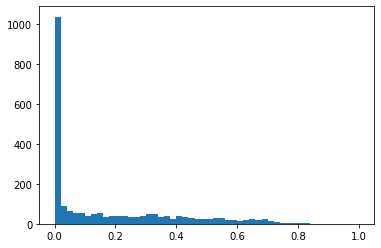

In [29]:
import matplotlib.pyplot as plt

plt.hist(results["dice"], bins=50, range=(0.0, 1.0))
plt.show()

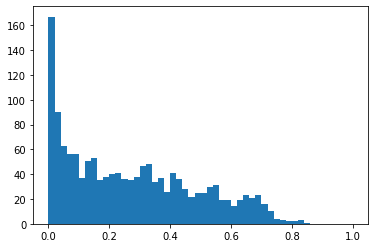

In [48]:
plt.hist(good_dice, bins=50, range=(0.0, 1.0))
plt.show()

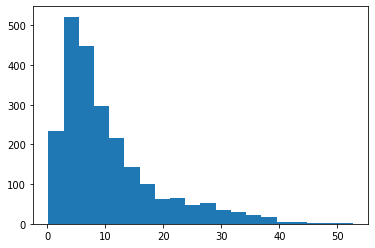

In [31]:
plt.hist(results["error"][results["error"] != np.inf], bins=20)
plt.show()

In [49]:
for f in Path(r"R:\DATASET_PROSTATE\numpy_160").iterdir():
    np.load(f)